# Image Preprocessing for PyTorch (Part 3/4)
Download | Structure | **Preprocessing (PyTorch)** | Train Model (PyTorch)

**Notes**: 
* This notebook should be used with the conda_ptroech_latest_p36 kernel
* This notebook is part of a series of notebooks beginning with `01_download_data` and `02_structuring_data`. From here on it will focus on SageMaker's support for PyTorch. The next notebook in this series is `04c_pytorch_training`.
* You can also explore preprocessing with SageMaker's built-in algorithms and TensorFlow by running `03a_builtin_preprocessing` and `03b_tensorflow_preprocessing`, respectively.

<pre>
</pre>

In this notebook, you will create resizing and data augmentation transforms for trainging with PyTorch. You will also upload your dataset to S3 for training with SageMaker.


<pre>
</pre>

## Overview
* #### [Depedencies](#idg3c.1)
* #### [Defining resize and augmentation transformations](#idg3c.2)
* #### [Creating PyTorch datasets and dataloaders](#idg3c.3)
* #### [Visualizing the transforms](#idg3c.4)
* #### [Upload data to S3](#idg3c.5)

<pre>
</pre>

<a id='idg3c.1'></a>
## Dependencies
___
For this guide we'll use the SageMaker Python SDK version 2.9.2. By default, SageMaker Notebooks come with version 1.72.0. Other guides provided by Amazon may be set up to work with other versions of the Python SDK so you may wish to roll-back to 1.72.0. We will also be using PyTorch 1.6.0 which can also be rolled back at the end of this guide to 1.4.0.

### Update the SageMaker Python SDK and PyTorch

In [ ]:
import sys
original_sagemaker_version = !conda list | grep -E "sagemaker\s" | awk '{print $2}'
original_pytorch_version = !conda list | grep -E "torch\s" | awk '{print $2}'
!{sys.executable} -m pip install -q "sagemaker==2.9.2" "torch==1.6.0" "torchvision"

In [5]:
import uuid
import boto3
import torch
import shutil
import pickle
import pathlib
import sagemaker
import numpy as np
from tqdm import tqdm
import torchvision as tv
import matplotlib.pyplot as plt

In [ ]:
print(f"sagemaker updated  {original_sagemaker_version[0]} -> {sagemaker.__version__}")
print(f"pytorch   updated  {original_pytorch_version[0]} -> {torch.__version__}")

<pre>
</pre>

<a id='idg3c.2'></a>
## Define the Resize and Augmentation Transformations
___

### Resize
Before going to the GPU for training, all image data must have the same dimensions for length, width and channel. Typically, algorithms use a square format so the length and width are the same and many pre-made datasets areadly have the images nicely cropped into squares. However, most real-world datasets will begin with images in many different dimensions and ratios. In order to prep our dataset for training we will need to resize and crop the images if they aren't already square. 

This transformation is deceptivley simple. If we want to keep the images from looking squished or stretched, we need to crop it to a square *and* we want to make sure the important object in the image doesn't get cropped out. Unfortunately, there is no easy way to make sure each crop is optimal so we typically choose a center crop which works well most of the time.

In [4]:
resize = tv.transforms.Compose(
    [tv.transforms.Resize(224), tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]
)

In [5]:
sample = tv.datasets.ImageFolder(root="data_structured/train", transform=tv.transforms.ToTensor())

sample_resized = tv.datasets.ImageFolder(root="data_structured/train", transform=resize)

In [6]:
sample = iter(sample)
sample_resized = iter(sample_resized)

Re-rull the cell below to sample another image

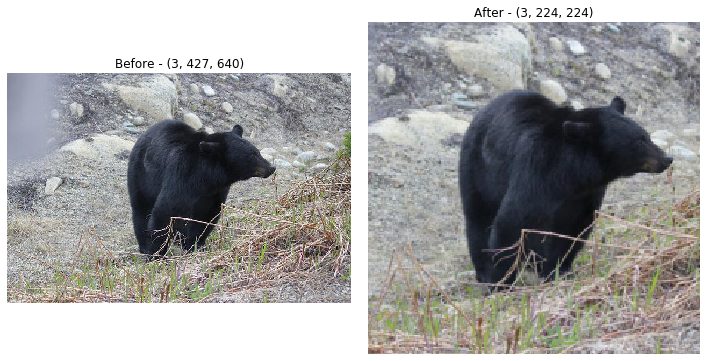

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_resized = next(iter(sample_resized))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_resized.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_resized.shape)}")
plt.tight_layout()

<pre>
</pre>

### Augmentation
An easy way to improve trainging is to randomly augment the images to help our training algorithm generalize better. Threre are many augmentations to choose from, but keep in mind that the more we add to our augment function, the more processing will be required before we can send the image to the GPU for training. Also, it's important to note that we don't need to augment the validation data because we want to generate a prediction on the image as it normally would be presented.

In [8]:
augment = tv.transforms.Compose(
    [
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(p=0.5),
        tv.transforms.RandomVerticalFlip(p=0.5),
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        tv.transforms.ToTensor(),
    ]
)

In [9]:
sample = tv.datasets.ImageFolder(root="data_structured/train", transform=tv.transforms.ToTensor())

sample_augmented = tv.datasets.ImageFolder(root="data_structured/train", transform=augment)

In [10]:
sample = iter(sample)
sample_augmented = iter(sample_augmented)

Re-rull the cell below to sample another image

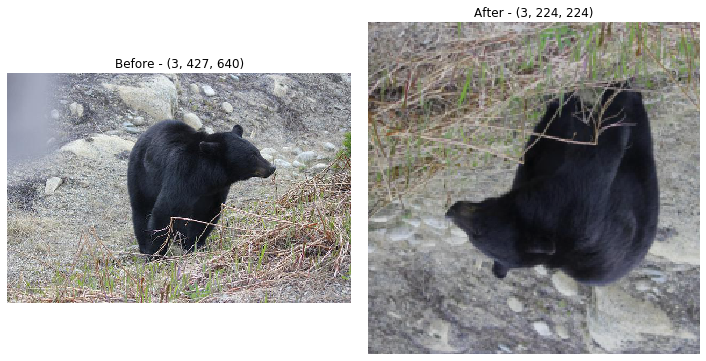

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_augmented = next(iter(sample_augmented))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_augmented.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_augmented.shape)}")
plt.tight_layout()

<pre>
</pre>

### A note on applying the transformations

The training data set will get the resize and augment functions applied to it, but the validation dataset only gets resized because it's not directly used for training. We will apply the transforms by passing them to the corresponding dataset with the `transform` kwarg. However, it doesn't actually transform the image yet. Rather, the transformation will be fully applied by the CPU right before it gets sent to the GPU for training. This is nice beause we can experiment quickly without having to wait for all the images to be transformed.

You may be wondering why we're applying the transformations randomly. This is done because our training algorithm will cycle through the data in epochs. Each epoch it will get a chance to view the image again so instead of sending the same image through each time, we'll apply a random augmentation. Ideally, we'd let the algorithm see all versions of the image each epoch, but this would scale the size of the training dataset by the number of augmentations. Scaling the data storage and training time by that factor isn't worth the relatively minor changes introduced into the dataset.

More documentation on all the transforms supported directly by Torchvision is available [here](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image)

In [12]:
data_transforms = {
    "train": tv.transforms.Compose(
        [
            tv.transforms.RandomResizedCrop(224),
            tv.transforms.RandomHorizontalFlip(p=0.5),
            tv.transforms.RandomVerticalFlip(p=0.5),
            tv.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            tv.transforms.ToTensor(),
        ]
    ),
    "val": tv.transforms.Compose(
        [tv.transforms.Resize(224), tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]
    ),
}

<pre>
</pre>

<a id='idg3c.3'></a>
## Create the PyTorch datasets and dataloaders
____

### Datasets
Datasets in PyTorch keep track of all the data in your dataset--where to find them (their path), what class they belong to and what transformations they get. In this case, we'll use PyTorch's handy `ImageFolder` to easily generate the dataset from the directory structure created in the previous guide.



In [13]:
data_dir = pathlib.Path("./data_structured")
splits = ["train", "val"]

datasets = {}
for s in splits:
    datasets[s] = tv.datasets.ImageFolder(root=data_dir / s, transform=data_transforms[s])

### Dataloaders
Dataloaders structure how the images get sent to the CPU and GPU for training. Thye include important hyper-parameters such as:
* **batch_size**: this tells the data loader how many images to send to the training algorithm at once for back propogagation. It will therefore also control the number to gradient updates which occur in one epoch for optimizers like SGD.
* **shuffle**: this will randomize the orders of your training data
* **num_workers**: this defines how many parallel processes you want to load and transform images before being sent to the GPU for training. Adding more workers will therefore speed up training. However, too many workers will slow training down due to the overhead of trying manage all the workers. Also, each worker will consume a considerable amount of RAM (depending on batch_size) and you cannot have more workers than cpu cores available on the EC2 instance used for training.

In [14]:
batch_size = 4
shuffle = True
num_workers = 4

dataloaders = {}
for s in splits:
    dataloaders[s] = torch.utils.data.DataLoader(
        datasets[s], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )

<pre>
</pre>

<a id='idg3c.4'></a>
## Visualize the transforms
___
Just to make sure everything is working we can apply some transformations on a few images and view them to make sure thye outout looks good. Simply re-run the cell to see a fresh batch of images.

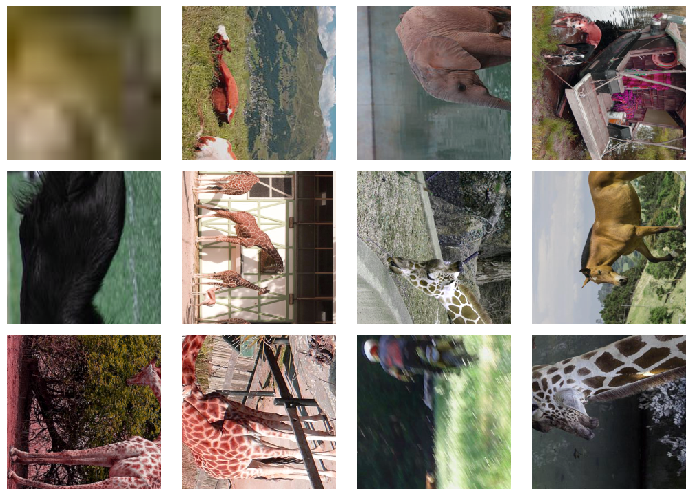

In [15]:
rows = 3
cols = batch_size
fig, axs = plt.subplots(rows, cols, figsize=(10, 7))

for row in range(rows):
    batch = next(iter(dataloaders["train"]))
    images, labels = batch
    for col, image in enumerate(images):
        ax = axs[row, col]
        ax.imshow(image.permute(2, 1, 0))
        ax.axis("off")

plt.tight_layout()

With your datasets and dataloaders defined, you're now ready to define the training architecture for your model.

<pre>
</pre>

<a id='idg3c.5'></a>
## Upload Data to S3
___

### Resize images and save to disk

In [16]:
data_dir = pathlib.Path("./data_structured")
splits = ["train", "val", "test"]

datasets = {}
for s in splits:
    datasets[s] = tv.datasets.ImageFolder(
        root=data_dir / s,
        transform=tv.transforms.Compose([tv.transforms.Resize(224), tv.transforms.ToTensor()]),
    )

In [ ]:
resized_path = pathlib.Path("./data_resized")
resized_path.mkdir(exist_ok=True)
for s in splits:
    split_path = resized_path / s
    split_path.mkdir(exist_ok=True)
    for idx, (img_tensor, label) in enumerate(tqdm(datasets[s])):
        label_path = split_path / f"{label:02}"
        label_path.mkdir(exist_ok=True)
        filename = datasets[s].imgs[idx][0].split("/")[-1]
        tv.utils.save_image(img_tensor, label_path / filename)

### Upload augmented images to S3

#### Create S3 bucket

In [ ]:
if pathlib.Path("pickled_data/pytorch_bucket_name.pickle").exists():
    with open("pickled_data/pytorch_bucket_name.pickle", "rb") as f:
        bucket_name = pickle.load(f)
        print("Bucket Name:", bucket_name)
else:
    bucket_name = f"sagemaker-pytorch-ic-{str(uuid.uuid4())}"
    s3 = boto3.resource("s3")
    region = sagemaker.Session().boto_region_name
    bucket_config = {"LocationConstraint": region}
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration=bucket_config)

    with open("pickled_data/pytorch_bucket_name.pickle", "wb") as f:
        pickle.dump(bucket_name, f)
    print("Bucket Name:", bucket_name)

#### Upload data to S3 (~3min)


In [20]:
s3_uploader = sagemaker.s3.S3Uploader()

for s in splits:
    data_s3_uri = s3_uploader.upload(
        local_path=(resized_path / s).as_posix(), desired_s3_uri=f"s3://{bucket_name}/data/{s}"
    )

<pre>
</pre>

## Rollback to default version of SDK and PyTorch
Only do this if you're done with this guide and want to use the same kernel for other notebooks with an incompatible version of the SageMaker SDK or PyTorch.

In [15]:
# print(f'Original version: sagemaker {original_sagemaker_version[0]}, torch {original_pytorch_version[0]}')
# print(f'Current version:  sagemaker {sagemaker.__version__}, torch {torch.__version__}')
# print('')
# print(f'Rolling back to sagemaker {original_sagemaker_version[0]}, torch {original_pytorch_version[0]}')
# print('Restart notebook kernel to use changes.')
# print('')
# s = f'sagemaker=={original_sagemaker_version[0]} torch=={original_pytorch_version[0]}'
# !{sys.executable} -m pip install -q {s}

<pre>
</pre>

## Next Steps
Now that the training and validations datasets are saved to S3, we can create a SageMaker Estimator for the PyTorch framework and run the training algorithm on a remote EC2 instance.